In [4]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Function to parse gzipped json
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

# Load first 100k rows
data = []
path = r"C:\Users\ramak\OneDrive\Documents\projects\Recommendation System\data\raw data\Electronics.json.gz" # Adjust filename if needed
for i, d in enumerate(parse(path)):
    if i >= 100000:
        break
    data.append(d)

df = pd.DataFrame(data)

# Show the basics
print(f"Shape: {df.shape}")
print(df.info())
df.head()

Shape: (100000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         100000 non-null  float64
 1   verified        100000 non-null  bool   
 2   reviewTime      100000 non-null  object 
 3   reviewerID      100000 non-null  object 
 4   asin            100000 non-null  object 
 5   style           59349 non-null   object 
 6   reviewerName    99992 non-null   object 
 7   reviewText      99986 non-null   object 
 8   summary         99992 non-null   object 
 9   unixReviewTime  100000 non-null  int64  
 10  vote            22593 non-null   object 
 11  image           609 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 8.5+ MB
None


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"07 17, 2002",A1N070NS9CJQ2I,0060009810,{'Format:': ' Hardcover'},Teri Adams,This was the first time I read Garcia-Aguilera...,Hit The Spot!,1026864000,NaN,NaN
1,5.0,False,"07 6, 2002",A3P0KRKOBQK1KN,0060009810,{'Format:': ' Hardcover'},Willa C.,"As with all of Ms. Garcia-Aguilera's books, I ...",one hot summer is HOT HOT HOT!,1025913600,NaN,NaN
2,5.0,False,"07 3, 2002",A192HO2ICJ75VU,0060009810,{'Format:': ' Hardcover'},Kit,I've not read any of Ms Aguilera's works befor...,One Hot Summer,1025654400,2,NaN
3,4.0,False,"06 30, 2002",A2T278FKFL3BLT,0060009810,{'Format:': ' Hardcover'},Andres,This romance novel is right up there with the ...,I love this book!,1025395200,3,NaN
4,5.0,False,"06 28, 2002",A2ZUXVTW8RXBXW,0060009810,{'Format:': ' Hardcover'},John,Carolina Garcia Aguilera has done it again. S...,One Hot Book,1025222400,NaN,NaN


In [5]:
# Basic Statistics
n_ratings = len(df)
n_users = df['reviewerID'].nunique()
n_items = df['asin'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique users: {n_users}")
print(f"Number of unique items: {n_items}")
print(f"Average ratings per user: {n_ratings / n_users:.2f}")

# Matrix Sparsity Calculation
# Formula: 1 - (Non-zero entries / Total possible entries)
sparsity = 1 - (n_ratings / (n_users * n_items))
print(f"Matrix Sparsity: {sparsity * 100:.4f}%")

Number of ratings: 100000
Number of unique users: 95191
Number of unique items: 1290
Average ratings per user: 1.05
Matrix Sparsity: 99.9186%


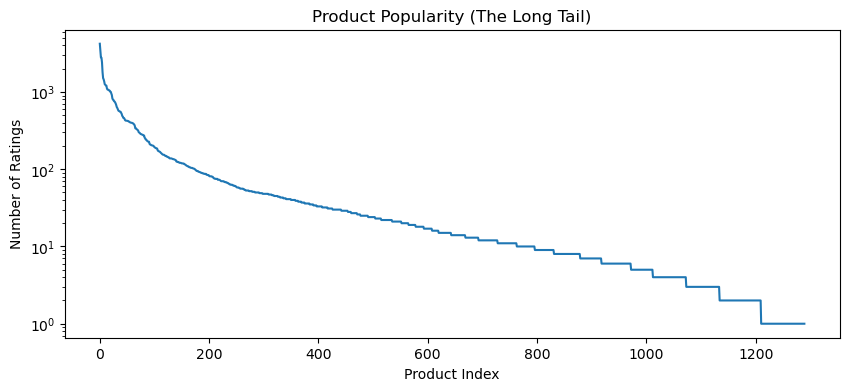

In [6]:
import matplotlib.pyplot as plt

# Count ratings per item
item_counts = df.groupby('asin')['overall'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
plt.plot(item_counts.values)
plt.title("Product Popularity (The Long Tail)")
plt.xlabel("Product Index")
plt.ylabel("Number of Ratings")
plt.yscale('log') # Log scale helps see the tail clearly
plt.show()

In [7]:
def filter_data(df, min_user_reviews=5, min_item_reviews=5):
    """
    Reduces sparsity by filtering out 'noisy' low-interaction users and items.
    """
    # Filter items
    item_counts = df.groupby('asin').size()
    active_items = item_counts[item_counts >= min_item_reviews].index
    df = df[df['asin'].isin(active_items)]
    
    # Filter users
    user_counts = df.groupby('reviewerID').size()
    active_users = user_counts[user_counts >= min_user_reviews].index
    df = df[df['reviewerID'].isin(active_users)]
    
    return df

def create_mappings(df):
    """
    RecSys models need integer IDs, not strings. 
    This creates a mapping for UserIDs and Asins.
    """
    user_map = {id: i for i, id in enumerate(df['reviewerID'].unique())}
    item_map = {id: i for i, id in enumerate(df['asin'].unique())}
    
    df['user_idx'] = df['reviewerID'].map(user_map)
    df['item_idx'] = df['asin'].map(item_map)
    
    return df, user_map, item_map

In [9]:
filtered_df = filter_data(df)

# Basic Statistics
n_ratings = len(filtered_df)
n_users = filtered_df['reviewerID'].nunique()
n_items = filtered_df['asin'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique users: {n_users}")
print(f"Number of unique items: {n_items}")
print(f"Average ratings per user: {n_ratings / n_users:.2f}")

# Matrix Sparsity Calculation
# Formula: 1 - (Non-zero entries / Total possible entries)
sparsity = 1 - (n_ratings / (n_users * n_items))
print(f"Matrix Sparsity: {sparsity * 100:.4f}%")

Number of ratings: 536
Number of unique users: 73
Number of unique items: 294
Average ratings per user: 7.34
Matrix Sparsity: 97.5026%
